### Summary
<div class="alert alert-block alert-info">
    <b>NOTE</b>: RNN modeling is performing poorly. It currently yields large MAE metrics (6.889, which is twice the MAE yielded by ARIMA). This is likely due to the particularly small dataset (only 1082 records even with resampling). Other recurrent neural networks could be explored here such as LSTMs and GRUs, but further exploration is required to determine whether to consider RNN modeling as a potential candidate.
</div>

### Imports

In [972]:
%pip install matplotlib
%pip install prophet
%pip install nbconvert
%pip install traitlets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from datetime import datetime
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import mse, rmse, meanabs, aic, bic
from pmdarima import auto_arima
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from statsmodels.tsa.arima.model import ARIMA
from statistics import median,mean
import matplotlib.ticker as ticker
import pytz
import warnings
import scipy.stats as st
import math
import seaborn as sns
from pylab import rcParams
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pika
import sys
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


[notice] A new release of pip available: 22.2.1 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.2.1 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.2.1 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Ingest Data

In [973]:
import json
import datetime
from datetime import timedelta
import random
import numpy as np
import pytz

data = pd.read_csv("../data/airlinetweets.csv", parse_dates=['tweet_created'], index_col=['tweet_created']).sort_index()
data
datetime.datetime.utcfromtimestamp(1661181327).replace(tzinfo=pytz.utc)

datetime.datetime(2022, 8, 22, 15, 15, 27, tzinfo=<UTC>)

## Exploratory Data Analysis

In [974]:
data.describe()
data_summary = data.groupby('airline_sentiment').resample('1d').count()[['tweet_id']]
data_summary = data_summary.unstack(0)
data_summary['total'] = data_summary.sum(axis = 1)
data_summary['tweet_id']['negative'].sum()

data_summary

tweet_id                    total
airline_sentiment         negative neutral positive        
tweet_created                                              
2015-02-16 00:00:00-08:00      3.0     1.0      NaN     4.0
2015-02-17 00:00:00-08:00    838.0   297.0    273.0  1408.0
2015-02-18 00:00:00-08:00    736.0   335.0    273.0  1344.0
2015-02-19 00:00:00-08:00    751.0   329.0    296.0  1376.0
2015-02-20 00:00:00-08:00    835.0   383.0    282.0  1500.0
2015-02-21 00:00:00-08:00   1049.0   278.0    230.0  1557.0
2015-02-22 00:00:00-08:00   2266.0   463.0    350.0  3079.0
2015-02-23 00:00:00-08:00   1919.0   676.0    433.0  3028.0
2015-02-24 00:00:00-08:00    781.0   337.0    226.0  1344.0

### Get Summary of Data

### Resample the data

In [975]:
#Resample the data
data['sentiment']=data['airline_sentiment'].map({'positive':1,'neutral':0,'negative':-1}) 
data_freq = 10 #in minutes
actual_positive_sentiments = data[data['sentiment']==1].resample(f'{data_freq}min').count()
actual_negative_sentiments = data[data['sentiment']==-1].resample(f'{data_freq}min').count()
actual_neutral_sentiments = data[data['sentiment']==0].resample(f'{data_freq}min').count()

In [976]:
import re
import pytz
import math

sample_frequencies = ['1min', '10min', '60min']

for sample_frequency in sample_frequencies:
    num_negative_in_past, sample_frequency_num = 0, int(re.findall(r'\d+', sample_frequency)[0])

    # offset_time = pytz.utc.localize(datetime.now()) - timedelta(minutes=sample_frequency_num)
    last_recorded_time = actual_negative_sentiments.sort_index().index[-1]
    offset_time = last_recorded_time - timedelta(minutes=sample_frequency_num)

    num_negative_in_past = actual_negative_sentiments.loc[actual_negative_sentiments.index >= offset_time]['sentiment'].sum()
    print(f"Number of negative posts in past {sample_frequency_num} minutes: {num_negative_in_past}")


Number of negative posts in past 1 minutes: 2
Number of negative posts in past 10 minutes: 21
Number of negative posts in past 60 minutes: 112


### Standardize the data

In [977]:
# Standardize the data
standard_scaler_positive_sentiment = StandardScaler()
standard_scaler_negative_sentiment = StandardScaler()
standard_scaler_neutral_sentiment = StandardScaler()

total_training_window = 1440 # (we assume a daily sample rate)

# The size of the sliding window
sliding_window_size = int(total_training_window/data_freq)

# The training data
standard_scaler_positive_sentiment.fit(actual_positive_sentiments[['sentiment']].iloc[:-sliding_window_size])
standard_scaler_negative_sentiment.fit(actual_negative_sentiments[['sentiment']].iloc[:-sliding_window_size])
standard_scaler_neutral_sentiment.fit(actual_neutral_sentiments[['sentiment']].iloc[:-sliding_window_size])

actual_positive_sentiments[['sentiment_normalized']] = \
    standard_scaler_positive_sentiment.transform(actual_positive_sentiments[['sentiment']])
actual_negative_sentiments[['sentiment_normalized']] = \
    standard_scaler_negative_sentiment.transform(actual_negative_sentiments[['sentiment']])
actual_neutral_sentiments[['sentiment_normalized']] = \
    standard_scaler_neutral_sentiment.transform(actual_neutral_sentiments[['sentiment']])

### Test for stationarity

In [978]:
adfuller(actual_negative_sentiments['sentiment_normalized'])[1]

0.03503054692717709

p-value is less than 0.05% - should imply stationarity

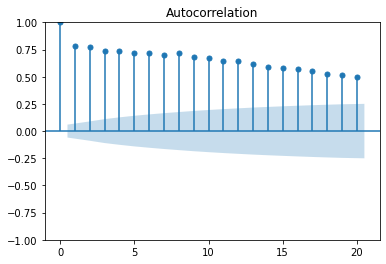

In [979]:
plot_acf(actual_negative_sentiments['sentiment'], lags=20);

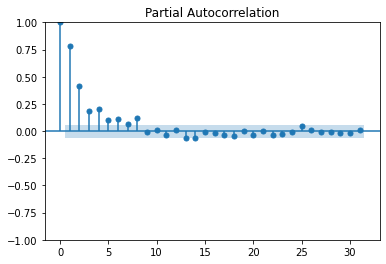

In [980]:
plot_pacf(actual_negative_sentiments['sentiment_normalized']);

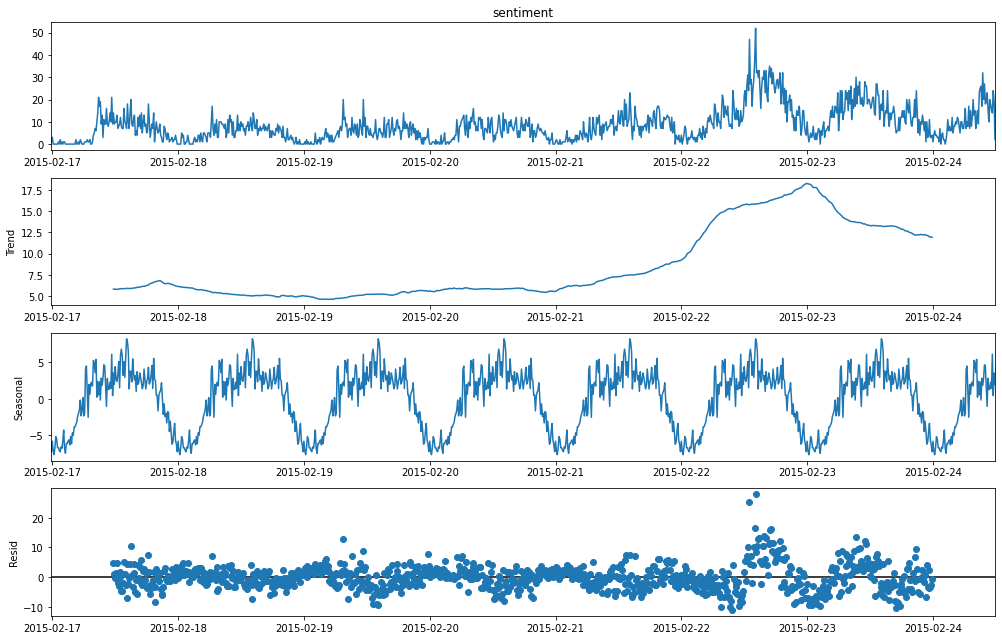

In [981]:
rcParams['figure.figsize'] = (14, 9)
the_decompose = seasonal_decompose(actual_negative_sentiments['sentiment'],model='additive',period=144);
the_decompose.plot();

### Plot Data

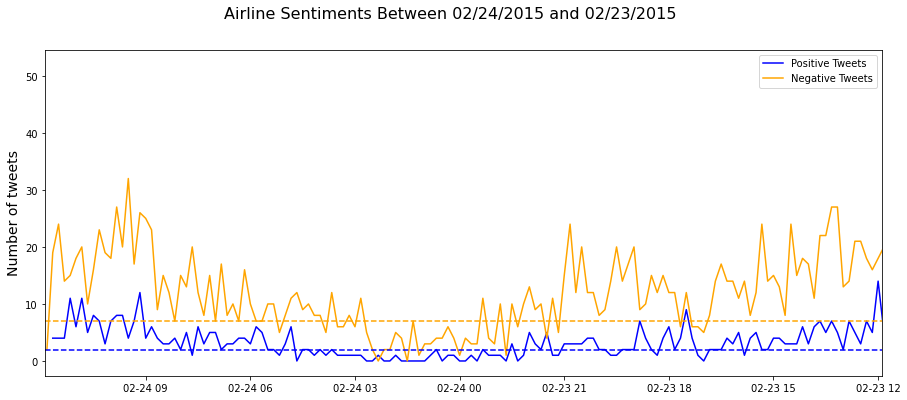

In [982]:
start_date, end_date = data['sentiment'].index.max(), data['sentiment'].index.min()

start_date, end_date = data['sentiment'].index.max(), data['sentiment'].index.max() - timedelta(days=1)

fig, ax = plt.subplots(figsize=(15, 6))

fig.suptitle(f"Airline Sentiments Between {start_date.strftime('%m/%d/%Y')} and {end_date.strftime('%m/%d/%Y')}", fontsize=16)

ax.set_xlim([start_date,end_date])
ax.plot(actual_positive_sentiments['sentiment'],
         label="Positive Tweets", color="blue")
ax.plot(actual_negative_sentiments['sentiment'],
         label="Negative Tweets", color="orange")
ax.hlines(actual_positive_sentiments['sentiment'].median(), xmin=start_date, xmax=end_date, linestyles='--', colors='blue')
ax.hlines(actual_negative_sentiments['sentiment'].median(), xmin=start_date, xmax=end_date, linestyles='--', colors='orange')
ax.set_ylabel('Number of tweets', fontsize=14)
ax.legend()

# Training

### Build a TimeSeries Generator

In [983]:
1 - int(test_period*2/data_freq) / len(actual_negative_sentiments)

0.7338262476894639

In [984]:
test_period = 1440 # (we assume a daily sample rate)

total_test_window = int(test_period*2/data_freq) 

# The size of the sliding window
sliding_window_size = int(test_period/data_freq)

train_test_split_percent = 1 - int(test_period*2/data_freq) / len(actual_negative_sentiments)

total_training_window = int(train_test_split_percent * len(actual_negative_sentiments))

# The training data
#actual_negative_sentiments_train = actual_negative_sentiments.iloc[:-total_test_window].dropna()
#actual_negative_sentiments_train = actual_negative_sentiments.iloc[:total_training_window].dropna()

# The test data
#actual_negative_sentiments_test = actual_negative_sentiments.iloc[-total_test_window:].dropna()
actual_negative_sentiments_test = actual_negative_sentiments.iloc[total_training_window:].dropna()

# number of outputs per batch
batch_length = int(test_period/data_freq)

# Number of batches per training cycle
timeseries_batch_size = 1

# Standardize the data
standard_scaler_rnn = StandardScaler()

standard_scaler_rnn.fit(actual_negative_sentiments_train[['sentiment']])

scaled_train = standard_scaler_rnn.transform(actual_negative_sentiments_train[['sentiment']])

scaled_test = standard_scaler_rnn.transform(actual_negative_sentiments_test[['sentiment']])

# Build the generator
generator = TimeseriesGenerator(scaled_train, 
                                scaled_train, 
                                length=batch_length, 
                                batch_size=timeseries_batch_size)

## Training / Validation

In [985]:
num_features=1
rnn_model = Sequential()
rnn_model.add(SimpleRNN(150, input_shape=(batch_length,num_features)))
rnn_model.add(Dense(1))
rnn_model.compile(optimizer='adam', loss='mae')
rnn_model.summary()

Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_15 (SimpleRNN)   (None, 150)               22800     
                                                                 
 dense_81 (Dense)            (None, 1)                 151       
                                                                 
Total params: 22,951
Trainable params: 22,951
Non-trainable params: 0
_________________________________________________________________


### Implement Early Stopping

In [986]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)
# build validation batch generator to be used by early stopping
validation_generator = TimeseriesGenerator(scaled_test, 
                                           scaled_test, 
                                           length=batch_length, 
                                           batch_size=timeseries_batch_size)

### Fit Model with Validation

In [987]:
rnn_model.fit_generator(generator, epochs=40, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/40
938/938 [==============================] - 16s 15ms/step - loss: 0.5256 - val_loss: 0.5336
Epoch 2/40
938/938 [==============================] - 14s 15ms/step - loss: 0.5564 - val_loss: 0.6180
Epoch 3/40
938/938 [==============================] - 14s 15ms/step - loss: 0.5638 - val_loss: 0.5885


### View losses

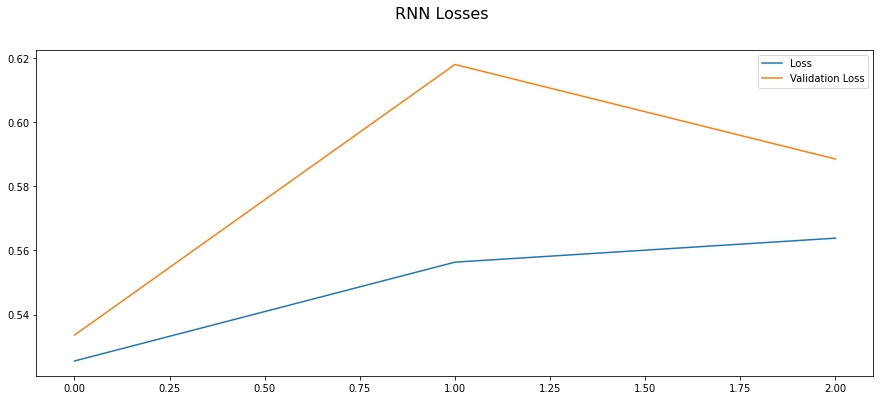

In [988]:
fig, ax = plt.subplots(figsize=(15, 6))
fig.suptitle("RNN Losses", fontsize=16)
losses = pd.DataFrame(rnn_model.history.history)
ax.plot(pd.DataFrame(losses['loss']), label="Loss")
ax.plot(pd.DataFrame(losses['val_loss']), label="Validation Loss")
ax.legend(loc='best')

### Generate fitted values

In [989]:
num_predictions = len(scaled_test) #len(generator) #like num_sliding_windows
pred_date_index = pd.date_range(end=actual_negative_sentiments_test.index[-1],periods=num_predictions, freq='10T')
eval_batch = scaled_train[-batch_length:].reshape(1, batch_length, num_features)
scaled_predictions = []

for i in np.arange(num_predictions):
    scaled_prediction = rnn_model.predict(eval_batch)
    eval_batch = np.append(eval_batch[:,1:,:], [scaled_prediction], axis=1)
    scaled_predictions.append(scaled_prediction)
    
predictions = standard_scaler_rnn.inverse_transform(np.reshape(scaled_predictions, (num_predictions, 1)))
rnn_predictions = pd.Series(predictions.reshape(-1), index=actual_negative_sentiments_test.index)#pred_date_index #actual_negative_sentiments.index[-num_predictions:])
rnn_predictions

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


tweet_created
2015-02-22 12:00:00-08:00     6.829419
2015-02-22 12:10:00-08:00     5.377653
2015-02-22 12:20:00-08:00     5.075824
2015-02-22 12:30:00-08:00     4.758056
2015-02-22 12:40:00-08:00     4.612151
                               ...    
2015-02-24 11:10:00-08:00    10.679729
2015-02-24 11:20:00-08:00    10.679731
2015-02-24 11:30:00-08:00    10.679730
2015-02-24 11:40:00-08:00    10.679732
2015-02-24 11:50:00-08:00    10.679734
Freq: 10T, Length: 288, dtype: float32

### Plot Predictions vs Actual

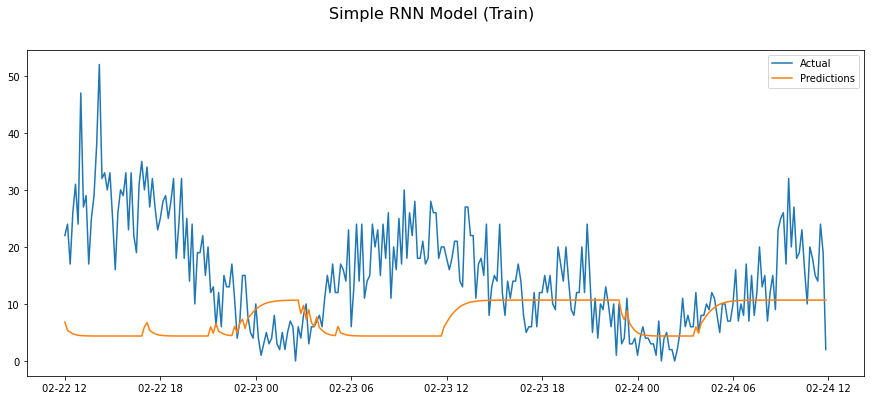

In [990]:
fig, ax = plt.subplots(figsize=(15, 6))
fig.suptitle("Simple RNN Model (Train)", fontsize=16)
ax.plot(actual_negative_sentiments_test['sentiment'], label="Actual")
ax.plot(rnn_predictions, label="Predictions")
ax.legend(loc='best')

### Detect Anomalies

In [991]:
z_score = st.norm.ppf(.95) #95% confidence interval
mae_scale_factor = 0.67449 # MAE is 0.67449 * std
mae = median_absolute_error(rnn_predictions,actual_negative_sentiments_test['sentiment'])

threshold = median(rnn_predictions) + (z_score/mae_scale_factor)*mae
model_RNN_results_metrics = \
    pd.DataFrame({ 'fittedvalues' : rnn_predictions, \
      'median_values' : rnn_predictions.rolling(4).median().fillna(0)}, \
       index = rnn_predictions.index )
model_RNN_results_metrics['threshold'] = model_RNN_results_metrics['median_values'] + (z_score/mae_scale_factor)*mae
model_RNN_results_metrics['anomaly'] = 0

model_RNN_results_metrics['actualvalues'] = actual_negative_sentiments_test['sentiment']
model_RNN_results_metrics['actualvalues'].fillna(0,inplace=True)

model_RNN_results_metrics.loc[model_RNN_results_metrics['actualvalues'] > model_RNN_results_metrics['threshold'],'anomaly']= 1
model_RNN_results_metrics['anomaly'].value_counts()

0    224
1     64
Name: anomaly, dtype: int64

### Plot Anomalies

Text(0.5, 1.0, 'RNN Model (Train): \n Median Absolute Error (MAE): 6.6226112842559814')

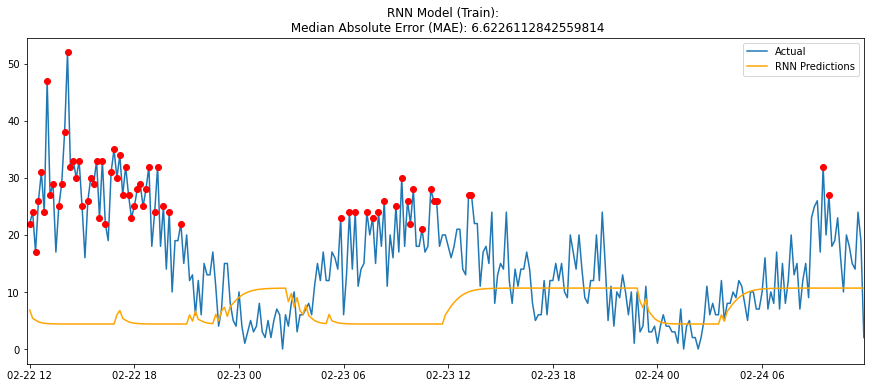

In [992]:
#start_date, end_date = actual_negative_sentiments_train.index[0], actual_negative_sentiments_train.index[-1]
start_date, end_date = actual_negative_sentiments_test.index[-1] - timedelta(hours=48), actual_negative_sentiments_test.index[-1]
#start_date, end_date = actual_negative_sentiments_train.index[0], actual_negative_sentiments_train.index[0] + timedelta(days=1)

fitted_values_actual = model_RNN_results_metrics.actualvalues
fitted_values_predicted = model_RNN_results_metrics.fittedvalues

mae_error = median_absolute_error(fitted_values_predicted,fitted_values_actual)

plt.figure(figsize=(15,6))
plt.xlim(start_date, end_date)
plt.plot(fitted_values_actual, label="Actual")
plt.plot(fitted_values_predicted, color='orange', label=f"RNN Predictions")
plt.plot(fitted_values_actual.loc[model_RNN_results_metrics['anomaly']==1], \
        marker='o', linestyle='None', color='red'
    )
plt.legend()

plt.title(f"RNN Model (Train): \n Median Absolute Error (MAE): {mae_error}")

# Forecasting

### Build a Timeseries Generator

In [993]:
test_period = 1440 # (we assume a daily sample rate)

total_test_window = -len(actual_negative_sentiments) # include the entire dataset

# The size of the sliding window
sliding_window_size = int(test_period/data_freq)

# The training data
actual_negative_sentiments_train = actual_negative_sentiments.iloc[:-total_test_window].dropna()

# number of outputs per batch
batch_length = int(test_period/data_freq)

# Number of batches per training cycle
timeseries_batch_size = 1

# Standardize the data
standard_scaler_rnn = StandardScaler()

standard_scaler_rnn.fit(actual_negative_sentiments_train[['sentiment']])

scaled_train = standard_scaler_rnn.transform(actual_negative_sentiments_train[['sentiment']])

# Build the generator
generator = TimeseriesGenerator(scaled_train, 
                                scaled_train, 
                                length=batch_length, 
                                batch_size=timeseries_batch_size)

### Train and Fit

In [994]:
num_features=1
rnn_model = Sequential()
rnn_model.add(SimpleRNN(150, input_shape=(batch_length,num_features)))
rnn_model.add(Dense(1))
rnn_model.compile(optimizer='adam', loss='mae')
rnn_model.summary()

Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_16 (SimpleRNN)   (None, 150)               22800     
                                                                 
 dense_82 (Dense)            (None, 1)                 151       
                                                                 
Total params: 22,951
Trainable params: 22,951
Non-trainable params: 0
_________________________________________________________________


### Fit Model

In [995]:
rnn_model.fit_generator(generator, epochs=40, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/40
938/938 [==============================] - 15s 15ms/step - loss: 0.6062 - val_loss: 0.5854
Epoch 2/40
938/938 [==============================] - 14s 15ms/step - loss: 0.5194 - val_loss: 0.5319
Epoch 3/40
938/938 [==============================] - 15s 16ms/step - loss: 0.4935 - val_loss: 0.5615
Epoch 4/40
938/938 [==============================] - 15s 16ms/step - loss: 0.4865 - val_loss: 0.5113
Epoch 5/40
938/938 [==============================] - 14s 15ms/step - loss: 0.4776 - val_loss: 0.6721
Epoch 6/40
938/938 [==============================] - 15s 16ms/step - loss: 0.4697 - val_loss: 0.5182


### View Losses

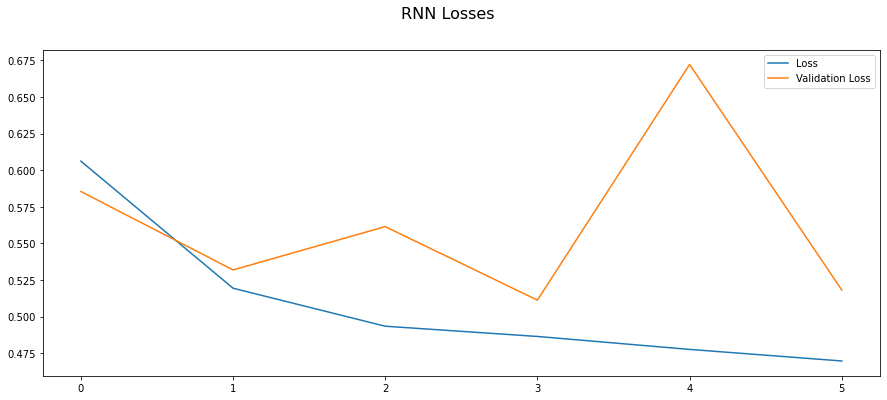

In [996]:
fig, ax = plt.subplots(figsize=(15, 6))
fig.suptitle("RNN Losses", fontsize=16)
losses = pd.DataFrame(rnn_model.history.history)
ax.plot(pd.DataFrame(losses['loss']), label="Loss")
ax.plot(pd.DataFrame(losses['val_loss']), label="Validation Loss")
ax.legend(loc='best')

### Generate fitted values

In [997]:
num_predictions = 144 #1440-minute forecast window
pred_date_index = pd.date_range(start=actual_negative_sentiments_test.index[-1],periods=num_predictions, freq='10T')
eval_batch = scaled_train[-batch_length:].reshape(1, batch_length, num_features)
scaled_predictions = []

for i in np.arange(num_predictions):
    scaled_prediction = rnn_model.predict(eval_batch)
    eval_batch = np.append(eval_batch[:,1:,:], [scaled_prediction], axis=1)
    scaled_predictions.append(scaled_prediction)
    
predictions = standard_scaler_rnn.inverse_transform(np.reshape(scaled_predictions, (num_predictions, 1)))
rnn_predictions = pd.Series(predictions.reshape(-1), index=pred_date_index)
rnn_predictions

1/1 [==============================] - 0s 22ms/step


2015-02-24 11:50:00-08:00    14.004357
2015-02-24 12:00:00-08:00    14.841702
2015-02-24 12:10:00-08:00    15.344475
2015-02-24 12:20:00-08:00    16.057037
2015-02-24 12:30:00-08:00    14.755700
                               ...    
2015-02-25 11:00:00-08:00    17.407286
2015-02-25 11:10:00-08:00    17.556013
2015-02-25 11:20:00-08:00    17.289370
2015-02-25 11:30:00-08:00    17.325396
2015-02-25 11:40:00-08:00    12.564715
Freq: 10T, Length: 144, dtype: float32

### Plot Predictions vs Actual

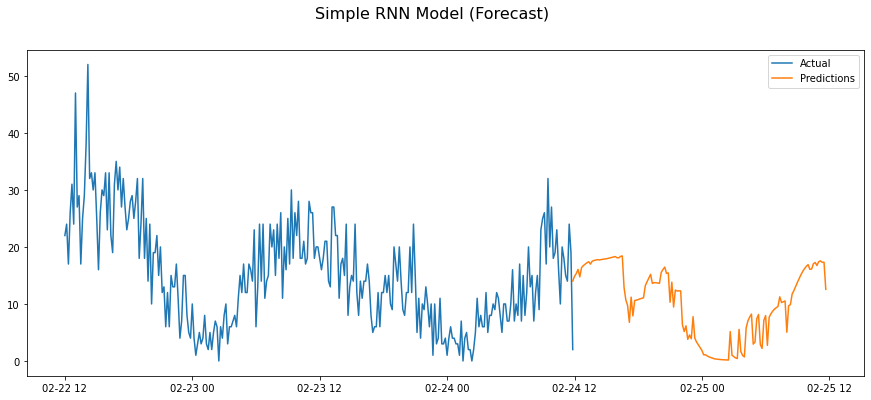

In [998]:
fig, ax = plt.subplots(figsize=(15, 6))
fig.suptitle("Simple RNN Model (Forecast)", fontsize=16)
ax.plot(actual_negative_sentiments_test['sentiment'], label="Actual")
ax.plot(rnn_predictions, label="Predictions")
ax.legend(loc='best')

### Detect Anomalies

In [999]:
actual_negative_sentiments_test[['sentiment']].iloc[-len(rnn_predictions):]

,sentiment
tweet_created,
2015-02-23 12:00:00-08:00,18
2015-02-23 12:10:00-08:00,16
2015-02-23 12:20:00-08:00,18
2015-02-23 12:30:00-08:00,21
2015-02-23 12:40:00-08:00,21
...,...
2015-02-24 11:10:00-08:00,15
2015-02-24 11:20:00-08:00,14
2015-02-24 11:30:00-08:00,24


In [1000]:
z_score = st.norm.ppf(.95) #95% confidence interval
mae_scale_factor = 0.67449 # MAE is 0.67449 * std
mae = median_absolute_error(rnn_predictions,actual_negative_sentiments_test[['sentiment']].iloc[-len(rnn_predictions):])

threshold = median(rnn_predictions) + (z_score/mae_scale_factor)*mae
model_RNN_results_metrics = \
    pd.DataFrame({ 'fittedvalues' : rnn_predictions, \
      'median_values' : rnn_predictions.rolling(4).median().fillna(0)}, \
       index = rnn_predictions.index )
model_RNN_results_metrics['threshold'] = model_RNN_results_metrics['median_values'] + (z_score/mae_scale_factor)*mae
model_RNN_results_metrics['anomaly'] = 0

model_RNN_results_metrics['actualvalues'] = actual_negative_sentiments_test['sentiment']
model_RNN_results_metrics['actualvalues'].fillna(0,inplace=True)

model_RNN_results_metrics.loc[model_RNN_results_metrics['fittedvalues'] > model_RNN_results_metrics['threshold'],'anomaly']= 1
model_RNN_results_metrics['anomaly'].value_counts()

0    141
1      3
Name: anomaly, dtype: int64

### Plot Anomalies

Text(0.5, 1.0, 'RNN Model (Forecast): \n Median Absolute Error (MAE): 11.035226345062256')

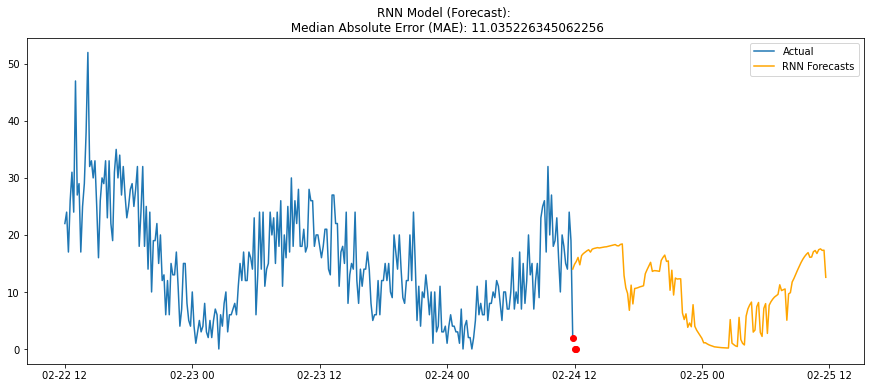

In [1001]:
#start_date, end_date = actual_negative_sentiments_train.index[0], actual_negative_sentiments_train.index[-1]
#start_date, end_date = actual_negative_sentiments_test.index[-1] - timedelta(hours=48), actual_negative_sentiments_test.index[-1]
#start_date, end_date = actual_negative_sentiments_train.index[0], actual_negative_sentiments_train.index[0] + timedelta(days=1)

fitted_values_actual = model_RNN_results_metrics.actualvalues
fitted_values_predicted = model_RNN_results_metrics.fittedvalues

mae_error = median_absolute_error(fitted_values_predicted,fitted_values_actual)

plt.figure(figsize=(15,6))
#plt.xlim(start_date, end_date)
#plt.plot(fitted_values_actual, label="Actual")
plt.plot(actual_negative_sentiments_test['sentiment'], label='Actual')
plt.plot(fitted_values_predicted, color='orange', label=f"RNN Forecasts")
plt.plot(fitted_values_actual.loc[model_RNN_results_metrics['anomaly']==1], \
        marker='o', linestyle='None', color='red'
    )
plt.legend()

plt.title(f"RNN Model (Forecast): \n Median Absolute Error (MAE): {mae_error}")

In [1002]:
base_predictions = pd.concat([pd.Series(), pd.Series(predictions.reshape(-1))])[-len(actual_negative_sentiments_test):]
base_predictions.reindex(actual_negative_sentiments_test.index)
base_predictions

0      14.004357
1      14.841702
2      15.344475
3      16.057037
4      14.755700
         ...    
139    17.407286
140    17.556013
141    17.289370
142    17.325396
143    12.564715
Length: 144, dtype: float32